# Tarea Final Herramientas Computacionales
---
***Nicolas Mantilla - 2210707***  
***Sofía Cárdenas - 2201381***  
***Sharith Pinzón - 2210709***

In [1]:
#Se importan las librerías necesiarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Lectura de archivos

In [2]:
#Se importan los datos utilizando pandas. Los datos están alojados en la carpeta data del repositorio
data_active = pd.read_csv("../data/Global_active_power.csv",delimiter=",",header=0)
data_intensity = pd.read_csv("../data/Global_intensity.csv",delimiter=",",header=0)
data_reactive = pd.read_csv("../data/Global_reactive_power.csv",delimiter=",",header=0)
data_voltage = pd.read_csv("../data/Voltage.csv",delimiter=",",header=0)

## 2. Fusión de los cuatro archivos en uno solo

In [3]:
#Se unen los 4 archivos en uno solo utilizando como referencia la columna Datetime.
data = pd.merge(pd.merge(data_active, data_reactive, on=["Datetime"]),
                pd.merge(data_intensity, data_voltage, on=["Datetime"]),
                on=["Datetime"])

#Se convierten los datos a vatios/hora
data["Global_active_power"] = round(data["Global_active_power"]*1000/60, 3)
data["Global_reactive_power"] = round(data["Global_reactive_power"]*1000/60, 3)
data

,Datetime,Global_active_power,Global_reactive_power,Global_intensity,Voltage
0,2010-01-01 00:00:00,29.833,3.933,7.4,240.65
1,2010-01-01 00:01:00,29.667,3.900,7.4,240.07
2,2010-01-01 00:02:00,29.667,3.900,7.4,240.15
3,2010-01-01 00:03:00,29.100,3.100,7.2,240.26
4,2010-01-01 00:04:00,28.100,1.700,7.0,240.12
...,...,...,...,...,...
457390,2010-11-26 20:58:00,15.767,0.000,4.0,240.43
457391,2010-11-26 20:59:00,15.733,0.000,4.0,240.00
457392,2010-11-26 21:00:00,15.633,0.000,3.8,239.82
457393,2010-11-26 21:01:00,15.567,0.000,3.8,239.70


## 3. *Resample* de los datos

In [4]:
#Se pone la columna Datetime como índice para poder hacer el resample
data["Datetime"] = pd.to_datetime(data["Datetime"])
data = data.set_index(["Datetime"])

#Se utiliza el método resample y se realiza por día y por mes. Dropna elimina los NaNs de los sets
data_diario = data.resample("D").mean().dropna()
data_mensual = data.resample("M").mean().dropna()
data_diario

,Global_active_power,Global_reactive_power,Global_intensity,Voltage
Datetime,,,,
2010-01-01,14.169592,1.913614,3.537083,242.565722
2010-01-02,19.603921,1.444256,4.857778,243.631743
2010-01-03,15.031576,1.505511,3.757778,241.822778
2010-01-04,19.530562,1.672035,4.879028,241.754160
2010-01-05,15.279607,2.228298,3.929861,240.647167
...,...,...,...,...
2010-12-07,12.842301,3.309176,3.397222,240.218646
2010-12-08,6.130765,1.957152,1.623750,240.794931
2010-12-09,18.658474,2.330551,4.755694,241.619722


In [5]:
data_mensual

,Global_active_power,Global_reactive_power,Global_intensity,Voltage
Datetime,,,,
2010-01-31,21.677334,2.086377,5.430332,242.338522
2010-02-28,19.292318,1.824457,4.836624,242.002101
2010-03-31,19.500255,2.272798,4.920399,241.475284
2010-04-30,17.272230,2.159279,4.363496,241.442527
2010-05-31,17.932618,2.120356,4.551504,241.296151
2010-06-30,16.255105,2.425415,4.170282,240.888985
2010-07-31,12.982458,2.301545,3.337202,240.965167
2010-08-31,15.490872,2.180260,3.954423,241.422944
2010-09-30,16.625685,2.128339,4.223837,241.267517


## 4. Regresiones lineales

In [6]:
#Se importa la función curve_fit de scipy
from scipy.optimize import curve_fit as cf

#Se definen las relaciones a utilizar con curve_fit. rel1 funciona para las relaciones
#1 y 2, rel3 se utiliza para la relación 3
def rel1(x, a, b):
    return a*x+b

def rel3(x, a, b, c):
    return a*x[0]+b*x[1]+c

#Se automatiza el fit de las relaciones para que se haga tomando como parámetros el
#set de datos a analizar y el titulo (nombre del set de datos). La función retorna
#un DataFrame con los valores del error del ajuste asignado a cada relación
def fit(dataset, tittle):
    xdata = (dataset["Global_intensity"], dataset["Voltage"])
    ydata = dataset["Global_active_power"]
    label = ("Global active power", "Global intensity", "Voltage")
    Error = pd.DataFrame(np.zeros(6).reshape(3,2), columns=["Valor", "Relación"])
    for i in [1,2]:
        opt, cov = cf(rel1, xdata[i-1], ydata)
        cov = np.around(np.sqrt(np.diag(cov)), 3)
        x = np.linspace(xdata[i-1].min(), xdata[i-1].max(), 100)
        Error["Valor"][i-1] = np.sqrt(np.mean((ydata-rel1(xdata[i-1], *opt))**2))
        Error["Relación"][i-1] = i
        plt.figure(figsize=(8,6))
        plt.plot(x, rel1(x, *opt), 'r-', label=r'fit: {}$\pm${}'.format(np.around(tuple(opt), 3),tuple(cov)))
        plt.scatter(xdata[i-1], ydata, label="Original data")
        plt.xlabel(label[i])
        plt.ylabel(label[0])
        plt.title(tittle)
        plt.legend()
        plt.show()
        print("Los coeficientes son : {}".format(opt))
        print("El sigma de los coeficientes son : {}".format(cov))
        print("Error on fit is =", Error["Valor"][i-1])
    opt, cov = cf(rel3, [xdata[0], xdata[1]], ydata)
    cov = np.around(np.sqrt(np.diag(cov)), 3)
    x = (np.linspace(xdata[0].min(), xdata[0].max(), 100), np.linspace(xdata[1].min(), xdata[1].max(), 100))
    Error["Valor"][2] = np.sqrt(np.mean((ydata-rel3([xdata[0], xdata[1]], *opt))**2))
    Error["Relación"][2] = 3
    plt.figure(figsize=(8,6))
    plt.plot(x[0], rel3(x, *opt), 'r-', label=r'fit: {}$\pm${}'.format(np.around(tuple(opt), 3),tuple(cov)))
    plt.scatter(xdata[0], ydata, label="Original data")
    plt.ylabel(label[0])
    plt.xlabel(label[1]+" and "+ label[2])
    plt.title(tittle)
    plt.legend()
    plt.show()
    print("Los coeficientes son : {}".format(opt))
    print("El sigma de los coeficientes son : {}".format(cov))
    print("Error on fit is =", Error["Valor"][2])
    return Error

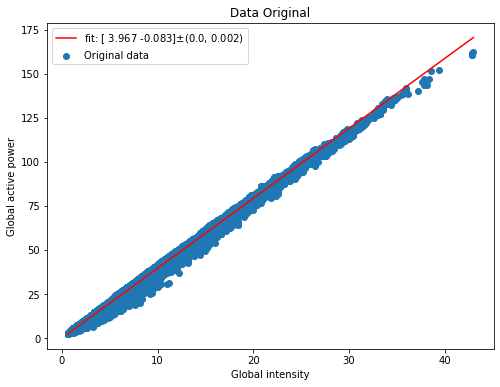

Los coeficientes son : [ 3.96710339 -0.08303341]
El sigma de los coeficientes son : [0.    0.002]
Error on fit is = 0.8209161926156007


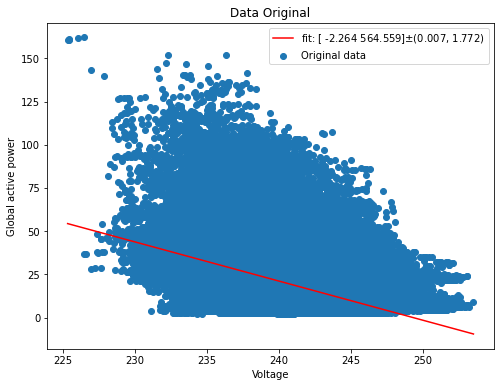

Los coeficientes son : [ -2.26434892 564.55880876]
El sigma de los coeficientes son : [0.007 1.772]
Error on fit is = 14.146558384377233


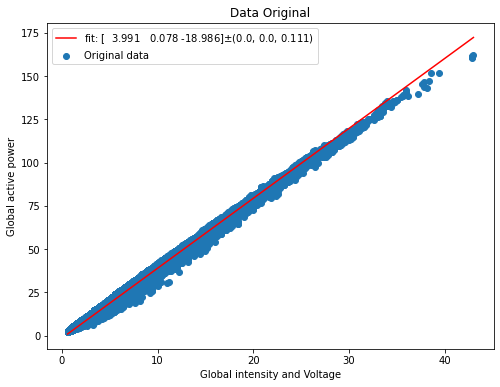

Los coeficientes son : [  3.9913327    0.07782028 -18.98634818]
El sigma de los coeficientes son : [0.    0.    0.111]
Error on fit is = 0.796031878544527


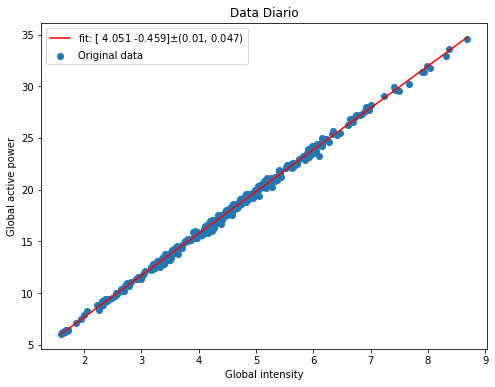

Los coeficientes son : [ 4.05096571 -0.45886981]
El sigma de los coeficientes son : [0.01  0.047]
Error on fit is = 0.2537458850640861


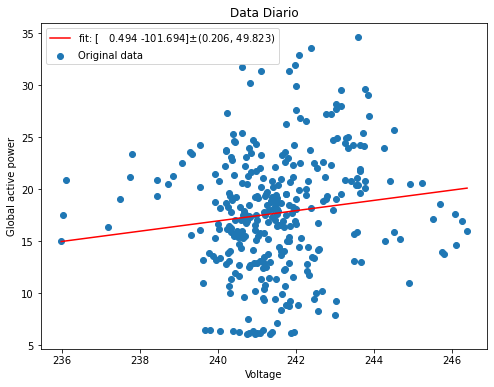

Los coeficientes son : [   0.49433747 -101.69429332]
El sigma de los coeficientes son : [ 0.206 49.823]
Error on fit is = 5.68804537817102


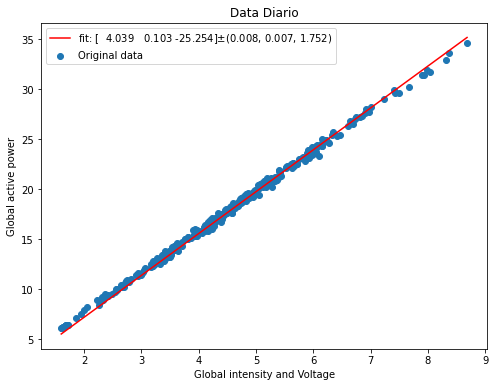

Los coeficientes son : [  4.03917433   0.10288216 -25.25430417]
El sigma de los coeficientes son : [0.008 0.007 1.752]
Error on fit is = 0.19898303113573979


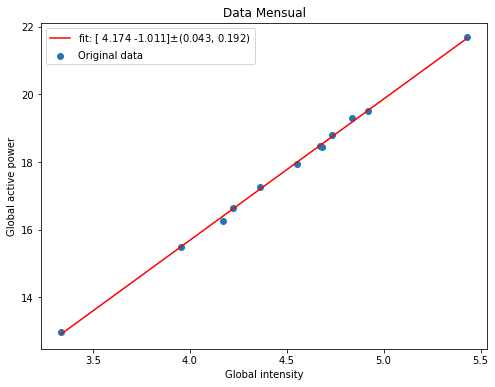

Los coeficientes son : [ 4.17380996 -1.01120187]
El sigma de los coeficientes son : [0.043 0.192]
Error on fit is = 0.06875914880677354


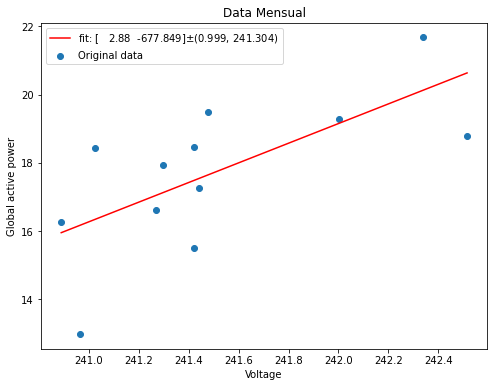

Los coeficientes son : [   2.88017288 -677.84904936]
El sigma de los coeficientes son : [  0.999 241.304]
Error on fit is = 1.5753671366447928


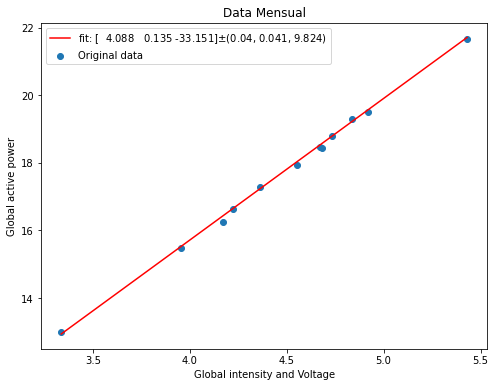

Los coeficientes son : [  4.08750041   0.13468723 -33.15135485]
El sigma de los coeficientes son : [0.04  0.041 9.824]
Error on fit is = 0.04646750823706416


In [7]:
#Se efectúa la regresión lineal de los datos con las 3 relaciones y se almacenan los errores.
Error_original = fit(data, "Data Original")
Error_diario = fit(data_diario, "Data Diario")
Error_mensual = fit(data_mensual, "Data Mensual")

## 5. Análisis y conclusiones

In [8]:
#Se halla e imprime la mejor y peor relación de cada set de datos encontrando los errores
#mínimos y máximos respectivamente
mejorRelacion_original = Error_original[Error_original["Valor"] == Error_original["Valor"].min()]
mejorRelacion_diario = Error_diario[Error_diario["Valor"] == Error_diario["Valor"].min()]
mejorRelacion_mensual = Error_mensual[Error_mensual["Valor"] == Error_mensual["Valor"].min()]
print("Mejor relación:", mejorRelacion_original, mejorRelacion_diario, mejorRelacion_mensual, sep="\n \n")

peorRelacion_original = Error_original[Error_original["Valor"] == Error_original["Valor"].max()]
peorRelacion_diario = Error_diario[Error_diario["Valor"] == Error_diario["Valor"].max()]
peorRelacion_mensual = Error_mensual[Error_mensual["Valor"] == Error_mensual["Valor"].max()]
print("\n Peor relación:", peorRelacion_original, peorRelacion_diario, peorRelacion_mensual, sep="\n \n")

Mejor relación:
 
      Valor  Relación
2  0.796032       3.0
 
      Valor  Relación
2  0.198983       3.0
 
      Valor  Relación
2  0.046468       3.0

 Peor relación:
 
       Valor  Relación
1  14.146558       2.0
 
      Valor  Relación
1  5.688045       2.0
 
      Valor  Relación
1  1.575367       2.0


**Como se observa en el bloque anterior:**
- La mejor relación (cuyo error es mínimo) es la relación ***3***
- La peor relación (cuyo error es máximo) es la relación ***2***

In [9]:
#Se realiza el promedio de los errores de cada relación en cada set de datos para encontrar
#el set que tenga el menor promedio de error
mejorSet = pd.DataFrame([[Error_original["Valor"].mean(), "Error original"],
                         [Error_diario["Valor"].mean(), "Error diario"],
                         [Error_mensual["Valor"].mean(), "Error mensual"]],
                       columns=["Promedio", "Data Set"])
mejorSet = mejorSet[mejorSet["Promedio"] == mejorSet["Promedio"].min()]
mejorSet

,Promedio,Data Set
2,0.563531,Error mensual


**Como se observa en el bloque anterior:**
- El mejor set de datos (cuyo promedio de errores es menor) es en el que se hizo el *resample* ***mensual***

<3

<img src="https://media.giphy.com/media/plcoWBSrPvOP6/giphy.gif" width=60%>